### Проведите сегментацию пользователей с помощью RFM анализа, с разделением каждого подсегмента (R,F,M) на 4 класса, и ответьте на вопросы: 

1.Какое максимальное кол-во покупок было совершено одним пользователем?  
2.Какая верхняя граница у суммы покупок у пользователей чья сумма покупок попадает в 4 класс в подсегменте М?  
3.Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?  
4.Сколько пользователей попало в сегмент 311?  
5.В каком RFM-сегменте самое большое кол-во пользователей?  

Импортируем необходимые библиотеки:

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Загрузим и посмотрим данные:

In [79]:
df=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-ronzhin/RFM_ht_data.csv', low_memory=False)
df

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2020-09-30,3801.87
332726,S0081810310461,99065678,2020-09-30,5769.88
332727,S0081810310462,19029918,2020-09-30,736.88
332728,S0081810310463,13020033,2020-09-30,1475.20


Посмотрим на типы данных:

In [80]:
df.dtypes

InvoiceNo        object
CustomerCode     object
InvoiceDate      object
Amount          float64
dtype: object

Переведем колонку с датой в соотвествующий тип данных:

In [81]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

Последняя дата покупок, от которой мы будем считать давность покупок каждого клиента:

In [82]:
last_date = df['InvoiceDate'].max()
last_date

Timestamp('2020-09-30 00:00:00')

Построим датасет, который для каждого пользователя сосчитает все необходимые для RFM анализа показатели:  
    1.Кол-во дней после последней покупки (Recency)  
    2.Кол-во заказов (Frequency)  
    3.Общую выручку всех заказов клиента (Monetary_Value)  

In [83]:
rfmTable = df.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency
                                        'InvoiceNo': lambda x: len(x),      # Frequency 
                                        'Amount': lambda x: x.sum()}) # Monetary Value 

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int) #перевод в int
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True) #переименование колонок


In [84]:
rfmTable

,recency,frequency,monetary_value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88
...,...,...,...
99099927,10,1,961.10
99099936,0,1,1521.78
99099959,8,2,1444.56


Убедимся что при создании датасета уникальные клиенты не потерялись:

In [85]:
df['CustomerCode'].nunique()==df['CustomerCode'].nunique()

True

Зададим квантили в этом датасете:

In [87]:
quantiles=rfmTable.quantile(q=[0.25,0.50,0.75])
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


Зададим функции присвоения класса от 1 до 4. Для R - по убыванию (меньше дней - выше класс), для F и М - по возрастающей (больше денег и заказов - выше класс)

In [88]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1


Создадим новый датасет на основе старого rfmTable:

In [89]:
rfmSegmentation = rfmTable

Применим функции к колонкам для каждого пользователя - определим к какому классу от 1 до 4 относится его показатель. В конце создадим сводную колонку всех подсегментов.

In [90]:

rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)\
                              + rfmSegmentation.F_Quartile.map(str)\
                              + rfmSegmentation.M_Quartile.map(str)

In [91]:
rfmSegmentation.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443


Сделаем FR анализ в виде таблицы распределения пользователей по сегментам:

In [92]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14433,4671,5795,6074
2,9634,5889,8633,10399
3,3091,3748,7734,13263
4,542,1311,5415,23101


Сделаем визуализацию RFM распределения, с указанием медианной суммы покупок для каждого сегмента с соотвествующей его прокраской

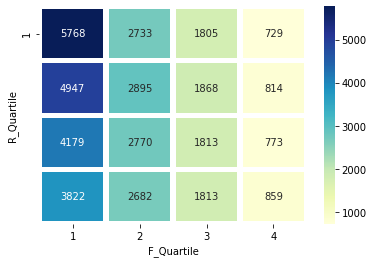

In [93]:

rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

### 1. Какое максимальное кол-во покупок было совершено одним пользователем?

In [94]:
rfmSegmentation['frequency'].max()

204

### 2. Какая верхняя граница у суммы покупок у пользователей чья сумма покупок попадает в 4й класс в подсегменте М?  

In [95]:
rfmSegmentation.query('M_Quartile=="4"').sort_values(['monetary_value'], ascending=False)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
70024801,15,2,765.00,3,3,4,334
19071804,4,1,765.00,2,4,4,244
13036504,13,2,765.00,3,3,4,334
13038952,19,1,765.00,4,4,4,444
35039364,2,1,765.00,1,4,4,144
...,...,...,...,...,...,...,...
13052590,11,1,9.50,3,4,4,344
19006298,15,1,5.00,3,4,4,344
13164125,28,1,2.64,4,4,4,444


В 4й, низший сегмент по выручке попадают клиенты, принесшие от минус 80.00 до 765.00. Ответ: 765.

### 3. Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?

In [96]:
rfmSegmentation.query('F_Quartile=="1"').sort_values(['frequency'])

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213129,1,4,2199.00,1,1,2,112
13272658,3,4,8738.05,2,1,1,211
13272725,0,4,4822.24,1,1,1,111
13272763,7,4,1326.08,2,1,3,213
13272778,0,4,8941.10,1,1,1,111
...,...,...,...,...,...,...,...
99003061,0,90,398759.35,1,1,1,111
19080880,27,99,169930.72,4,1,1,411
13032521,0,106,389309.92,1,1,1,111


По количеству покупок в 1й класс попадают пользователи, купившие от 4 до 204 покупок. Ответ: 4

### 4. Сколько пользователей попало в сегмент 311?

In [97]:
rfmSegmentation.query('RFMClass=="311"').agg({'RFMClass':'count'})

RFMClass    1609
dtype: int64

Ответ: 1609 пользователей

### 5. В каком RFM-сегменте самое большое кол-во пользователей?

In [98]:
RFM_users=rfmSegmentation.groupby('RFMClass',as_index=True).agg({'RFMClass':'count'})
RFM_users=RFM_users.rename(columns={'RFMClass':'customers'})\
.sort_values('customers', ascending=False)\
.reset_index()
RFM_users

,RFMClass,customers
0,444,10624
1,111,9705
2,443,6729
3,344,6593
4,211,5847
...,...,...
59,424,63
60,214,60
61,114,60
62,314,33


Больше всего пользователей в сегменте 444 (10 624 пользователя), на втором месте идет сегмент с самыми прибыльными, лояльными и активными пользователями (сегмент 111 - 9 705 пользователей), самый малочисленный сегмент 414 -2 пользователя